# Transformations

The aim of this notebook is to test different setups with transformations using cross-validation and measure top f1 score over all epochs and folds.

NB! Running this notebook takes roughly 7-8 hours on a GPU.

## Imports

In [1]:
import os
import cv2
import torch
import albumentations as A
import pandas as pd
import numpy as np
import itertools
import segmentation_models_pytorch as smp
import time
import random

from sklearn.model_selection import KFold
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model
from torch.utils.data import DataLoader, SubsetRandomSampler
from IPython.display import clear_output

In [2]:
# Add a time delay before starting the cross validation

# hours = 1
# minutes = 0
# 
# for sec in range(minutes*60 + hours*3600, 0, -1):
#     print(f"Starting in {int(sec/3600)}:{int(sec%3600 / 60):}:{sec % 60}", end="\r")
#     time.sleep(1)

In [3]:
import sys
import glob

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('transformations.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Data

In [4]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [5]:
# image paths so that all the images are used for train dataset (no test set for cv due to small training set)
image_path_train, _, mask_path_train, _ = split_data(train_directory, test_size=0)

# create train Dataset without transformations for now
train_dataset = RoadDataset(image_path_train, mask_path_train)

## Hyperparameters

Since our aim is to see, how different transformations influence the training, we fix the model, epochs and batch sizes.

In [6]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

SEED = 16
BATCH_SIZE = 4
K_FOLD = 3
N_CPU = os.cpu_count()
N_EPOCHS = 100

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

# Albumentations use many separate image augmentation libraries with different sources for randomization. This is the best effort to have reproducible results. 
random.seed(SEED)
np.random.seed(SEED)

## Transformations

Define transformations we'll use in evaluating the performance of the model.

In [7]:
# Transforms that will always be applied
base_tf = [A.Resize(height=608, width=608, always_apply=True)]

# Optional transforms that we want to test
transforms_dict = {
    "flip": A.Flip(p=0.5),
    "rotate": A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    "brightness": A.RandomBrightnessContrast(p=0.5),
    "shadow": A.RandomShadow(p=0.5,num_shadows_lower=1, num_shadows_upper=4),
    "coarse dropout": A.CoarseDropout(max_holes=8, max_height=50, max_width=50, min_holes=None, min_height=25, min_width=25,)
}

In [8]:
# initiate the setups for transformations
col_names = transforms_dict.keys()

# Test optional transforms:
# 1. No transform
# 2. All transforms individually
# 3. All possible pairs of transforms
transform_combinations = [()] + list(itertools.combinations(col_names, 1)) + list(itertools.combinations(col_names, 2))
print(transform_combinations)

[(), ('flip',), ('rotate',), ('brightness',), ('shadow',), ('coarse dropout',), ('flip', 'rotate'), ('flip', 'brightness'), ('flip', 'shadow'), ('flip', 'coarse dropout'), ('rotate', 'brightness'), ('rotate', 'shadow'), ('rotate', 'coarse dropout'), ('brightness', 'shadow'), ('brightness', 'coarse dropout'), ('shadow', 'coarse dropout')]


## Cross-Validation

This cross validation on 16 different combinations took around 7h to train on a RTX 3070 with following presets:
```
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
K_FOLD = 3
N_EPOCHS = 100
model = "DeepLabV3Plus"
```



In [9]:
metric_dict = {}

for setup in transform_combinations:

    clear_output(wait=True)
    print(f'setup: {str(setup)}')

    # get the picked tfs as list
    tf_selection = base_tf + [transforms_dict[t] for t in setup]

    k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

    # Record K-fold results in a (K_FOLD, num_epoch) matrix
    training_f1_matrix = []
    validation_f1_matrix = []

    train_tf = A.Compose(base_tf + tf_selection)
    valid_tf = A.Compose(base_tf)

    # Get training and validation indices
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):
        
        print(f'fold: {fold}')

        # Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
        train_loader = DataLoader(train_dataset.set_tf(train_tf), sampler=SubsetRandomSampler(train_idx), **LOADER_PARAMS)
        valid_loader = DataLoader(train_dataset.set_tf(valid_tf), sampler=SubsetRandomSampler(val_idx), **LOADER_PARAMS)

        # Initialize model
        model_ = smp.create_model("DeepLabV3Plus", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
        criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
        scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_,
            T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
        )

        # Train model
        train_losses, valid_losses, train_f1s, valid_f1s = train_model(
            model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
        )

        # Save epoch results
        training_f1_matrix.append(np.array(train_f1s))
        validation_f1_matrix.append(np.array(valid_f1s))
    
    metric_dict[", ".join(setup)] = validation_f1_matrix

setup: ('shadow', 'coarse dropout')
fold: 0


Epoch:   1. Train.      Loss: 0.523 | f1: 0.517: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
Epoch:   1. Validation. Loss: 0.602 | f1: 0.419: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]
Epoch:   2. Train.      Loss: 0.342 | f1: 0.708: 100%|██████████| 17/17 [00:04<00:00,  3.69it/s]
Epoch:   2. Validation. Loss: 0.470 | f1: 0.573: 100%|██████████| 9/9 [00:00<00:00, 12.54it/s]
Epoch:   3. Train.      Loss: 0.256 | f1: 0.789: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
Epoch:   3. Validation. Loss: 0.399 | f1: 0.615: 100%|██████████| 9/9 [00:00<00:00, 12.24it/s]
Epoch:   4. Train.      Loss: 0.223 | f1: 0.805: 100%|██████████| 17/17 [00:04<00:00,  3.67it/s]
Epoch:   4. Validation. Loss: 0.270 | f1: 0.746: 100%|██████████| 9/9 [00:00<00:00, 12.27it/s]
Epoch:   5. Train.      Loss: 0.167 | f1: 0.848: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
Epoch:   5. Validation. Loss: 0.259 | f1: 0.717: 100%|██████████| 9/9 [00:00<00:00, 12.48it/s]
Epoch:   6. Train.      Loss: 0.150 | f1

fold: 1


Epoch:   1. Train.      Loss: 0.510 | f1: 0.547: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
Epoch:   1. Validation. Loss: 0.558 | f1: 0.562: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]
Epoch:   2. Train.      Loss: 0.335 | f1: 0.708: 100%|██████████| 17/17 [00:04<00:00,  3.66it/s]
Epoch:   2. Validation. Loss: 0.426 | f1: 0.608: 100%|██████████| 9/9 [00:00<00:00, 12.60it/s]
Epoch:   3. Train.      Loss: 0.241 | f1: 0.791: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
Epoch:   3. Validation. Loss: 0.439 | f1: 0.604: 100%|██████████| 9/9 [00:00<00:00, 12.63it/s]
Epoch:   4. Train.      Loss: 0.210 | f1: 0.805: 100%|██████████| 17/17 [00:04<00:00,  3.66it/s]
Epoch:   4. Validation. Loss: 0.245 | f1: 0.774: 100%|██████████| 9/9 [00:00<00:00, 12.40it/s]
Epoch:   5. Train.      Loss: 0.173 | f1: 0.834: 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]
Epoch:   5. Validation. Loss: 0.196 | f1: 0.807: 100%|██████████| 9/9 [00:00<00:00, 12.84it/s]
Epoch:   6. Train.      Loss: 0.138 | f1

fold: 2


Epoch:   1. Train.      Loss: 0.526 | f1: 0.503: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]
Epoch:   1. Validation. Loss: 0.591 | f1: 0.461: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s]
Epoch:   2. Train.      Loss: 0.349 | f1: 0.688: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
Epoch:   2. Validation. Loss: 0.491 | f1: 0.558: 100%|██████████| 9/9 [00:00<00:00, 12.69it/s]
Epoch:   3. Train.      Loss: 0.268 | f1: 0.753: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]
Epoch:   3. Validation. Loss: 0.387 | f1: 0.614: 100%|██████████| 9/9 [00:00<00:00, 12.48it/s]
Epoch:   4. Train.      Loss: 0.195 | f1: 0.812: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]
Epoch:   4. Validation. Loss: 0.234 | f1: 0.786: 100%|██████████| 9/9 [00:00<00:00, 12.85it/s]
Epoch:   5. Train.      Loss: 0.155 | f1: 0.844: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
Epoch:   5. Validation. Loss: 0.272 | f1: 0.744: 100%|██████████| 9/9 [00:00<00:00, 12.38it/s]
Epoch:   6. Train.      Loss: 0.150 | f1

## Metrics

We use the mean F1 score of each epoch as the representative value.

In [10]:
f1s = []
last_f1s = []
std_devs = []
last_std_devs = []

for matrix in metric_dict.values():
    # Each matrix corresponds to all the k-fold results of one transform 
    matrix = np.array(matrix)
    
    # Find the mean F1 of each epoch
    mean_per_epoch = matrix.mean(axis=0)
    
    # Save the F1 and std of the best epoch
    best_epoch = mean_per_epoch.argmax()
    f1s.append(mean_per_epoch.max())
    std_devs.append(matrix[:, best_epoch].std())
    
    # Save the F1 and std of the last epoch
    last_f1s.append(matrix[:,-1].mean())
    last_std_devs.append(matrix[:,-1].std())

In [11]:
# Construct a pandas df 
final_df = pd.DataFrame(index=metric_dict.keys(), columns=['top-f1', 'top-std', 'last-f1', 'last-std'], data=np.array([f1s, std_devs, last_f1s, last_std_devs]).T)
# Use timestamp in file name to avoid accidentally overwriting important results
final_df.to_csv(os.path.join(ROOT_PATH, 'data', 'results', 'transforms', f'transform_results_{int(time.time())}.csv'))
final_df

,top-f1,top-std,last-f1,last-std
,0.831390,0.014342,0.816525,0.022441
flip,0.843559,0.013918,0.815030,0.041812
rotate,0.851252,0.014290,0.833876,0.007608
brightness,0.836866,0.006375,0.815554,0.034975
shadow,0.835861,0.011437,0.827424,0.013765
coarse dropout,0.840128,0.005437,0.823945,0.019550
"flip, rotate",0.844831,0.016450,0.839956,0.017655
"flip, brightness",0.849629,0.014885,0.830302,0.024848
"flip, shadow",0.847847,0.016595,0.828594,0.025434
"flip, coarse dropout",0.842798,0.009798,0.837934,0.010435


In [15]:
# Generate the Latex table for our research paper
print(final_df.to_latex(columns=["top-f1", 'top-std'], header=["top-f1","std"], float_format="%.3f", caption="The best results k-fold (mean) result", label="table:transform-results", position="h!"))

\begin{table}[h!]
\caption{The best results k-fold (mean) result}
\label{table:transform-results}
\begin{tabular}{lrr}
\toprule
 & top-f1 & std \\
\midrule
 & 0.831 & 0.014 \\
flip & 0.844 & 0.014 \\
rotate & 0.851 & 0.014 \\
brightness & 0.837 & 0.006 \\
shadow & 0.836 & 0.011 \\
coarse dropout & 0.840 & 0.005 \\
flip, rotate & 0.845 & 0.016 \\
flip, brightness & 0.850 & 0.015 \\
flip, shadow & 0.848 & 0.017 \\
flip, coarse dropout & 0.843 & 0.010 \\
rotate, brightness & 0.855 & 0.008 \\
rotate, shadow & 0.850 & 0.013 \\
rotate, coarse dropout & 0.852 & 0.010 \\
brightness, shadow & 0.832 & 0.009 \\
brightness, coarse dropout & 0.839 & 0.012 \\
shadow, coarse dropout & 0.832 & 0.014 \\
\bottomrule
\end{tabular}
\end{table}


# Visualize Transformations

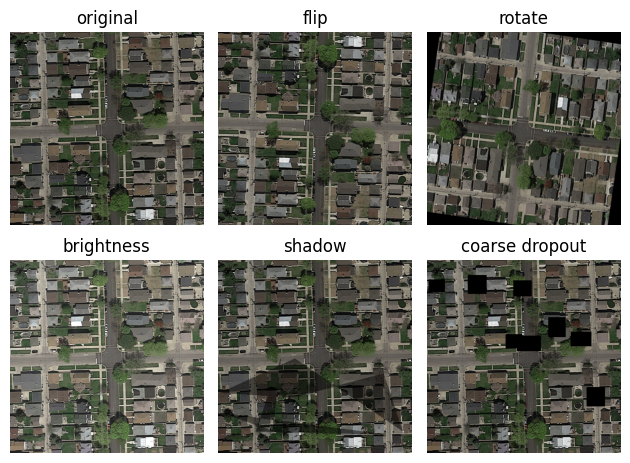

In [13]:
import math
import matplotlib.pyplot as plt

#transform = A.Compose(pd.Series(added_tfs).explode().tolist())

# 1 base image + 1 image per transform
image_count = 1 + len(transforms_dict)

# Collage column count can be chosen and row count will then be computed based on the number of images  
COLLAGE_COLUMNS = 3
COLLAGE_ROWS = math.ceil(image_count / COLLAGE_COLUMNS)

# Get sample image and change axis ordering back from Pytorch format
original_img = train_dataset[0][0]
original_img = np.moveaxis(original_img, 0, -1)

# Plot unaltered image
fig = plt.figure(layout='tight')
ax1 = fig.add_subplot(COLLAGE_ROWS, COLLAGE_COLUMNS, 1)
ax1.imshow(original_img, cmap="Greys_r")
ax1.set_title("original")
ax1.axis("off")

# Add image to the grid for each separate transform
for idx, (label, t) in enumerate(transforms_dict.items()):
    
    # Transformations are generally only applied with some probability e.g 0.5. Here we want to definitely apply it.
    t.always_apply=True 
    transformed_img = t(image=original_img)["image"]
    
    # Plot transformed image
    ax2 = fig.add_subplot(COLLAGE_ROWS, COLLAGE_COLUMNS, idx + 2)
    ax2.imshow(transformed_img)
    ax2.set_title(label)
    ax2.axis("off")
    ax2.margins(x=0.1, y=5)
    
fig.savefig(ROOT_PATH + "/data/results/transforms/transform_collage.png", dpi=100)